## Import libraries and python files

In [1]:
#import useful libraries 
import pandas as pd
import json
import sys
import requests
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm 
import statsmodels.formula.api as smf
%matplotlib inline 

from data_loader import *
%load_ext autoreload
%autoreload 2


##link to the datasets
## https://www.cs.cmu.edu/~ark/personas/
##https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?resource=download&select=movies_metadata.csv
##https://www.kaggle.com/datasets/ashirwadsangwan/imdb-dataset

## Load the different datasets

In [2]:
##load datasets from CMU dataset
df_character = load_character().copy()
df_movie = load_movie().copy()
df_name_cluster = load_name_cluster().copy()
df_summary = load_plot_summary().copy()
df_tropes_cluster = load_tropes_cluster().copy()

In [3]:
# Replace 'id-translation.wikidata.json' with the path to your JSON file
file_path = 'id-translation.wikidata.json'

# Load the JSON file into a DataFrame
df_id_translation = pd.read_json(file_path, orient='records', lines=True)

# Display the loaded DataFrame
# display(df_id_translation)

In [4]:
df_id_translation = df_id_translation.dropna(subset=['Freebase ID'])
df_id_translation.drop_duplicates(subset=['Freebase ID'], keep='first', inplace=True)

In [5]:
# df_movie will be the reference dataframe. After being completed with additional datasets, it can never be modified

df_movie = pd.merge(df_movie, df_id_translation, on='Freebase ID', how='left')
#display(df_movie)

In [6]:
#compute percentage of missing values for df_movie
values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']

def compute_missing_values(df, values):
    for variable in values :
        percentage_missing_values = (df[variable].isna().sum()/len(df[variable]))*100
        print(f"The percentage of missing values {variable} release date is {format(percentage_missing_values, '.3f')}%.")

    
compute_missing_values(df_movie, values)


The percentage of missing values Year release date is 8.444%.
The percentage of missing values Month release date is 51.832%.
The percentage of missing values Box office release date is 89.722%.
The percentage of missing values Runtime release date is 25.018%.
The percentage of missing values tconst release date is 9.769%.


In [7]:
##As we can see, a lot of 'Box office' data is missing

## Load addtionnal datasets and merge what we need 

In [8]:
#load imdb dataset (from kaggle)
df_imdb_movie = load_movie_imdb_kaggle()
df_imdb_rating = load_rating_imdb_kaggle() 

#merge movies with rating 
df_movie_rating = pd.merge(df_imdb_movie, df_imdb_rating, on='tconst', how='inner')

#display(df_movie_rating)


In [9]:
#merge CMU dataset with IMDB dataset
df_movie = pd.merge(df_movie, df_movie_rating[['tconst', 'averageRating', 'numVotes']], on=['tconst'], how='left')
#display(df_movie)


In [10]:
# missing Rating values
values = ['averageRating', 'numVotes']

compute_missing_values(df_movie, values)
print(f"The number of movies with missing values for 'averageRating' and 'numVotes' is {df_movie['averageRating'].isna().sum()}.")


The percentage of missing values averageRating release date is 31.271%.
The percentage of missing values numVotes release date is 31.271%.
The number of movies with missing values for 'averageRating' and 'numVotes' is 25561.


In [11]:
## load kaggle movie metadata
df_kaggle_movie = load_movie_kaggle()
#display(df_kaggle_movie)

In [12]:
#merge the datasets on the 'Name' column
#df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'Month', 'Day']], on=['Name', 'Year'], how='left', suffixes=('', '_df2'))
df_movie = df_movie.merge(df_kaggle_movie[['Name', 'Year', 'tconst', 'Month', 'Day']], on=['Name', 'Year','tconst'], how='left', suffixes=('', '_df2'))

In [13]:
#use 'combine_first' to fill in the 'Box office' values from df_kaggle_movie where they are NaN in df_movie
df_movie['Month'] = df_movie['Month'].combine_first(df_movie['Month_df2'])
df_movie['Day'] = df_movie['Day'].combine_first(df_movie['Day_df2'])

#drop the extra 'Box office' column from df_kaggle_movie
df_movie.drop('Month_df2', axis=1, inplace=True)
df_movie.drop('Day_df2', axis=1, inplace=True)
#display(df_movie)

In [14]:

values = ['Year', 'Month', 'Box office', 'Runtime', 'tconst']
compute_missing_values(df_movie, values)


The percentage of missing values Year release date is 8.442%.
The percentage of missing values Month release date is 42.891%.
The percentage of missing values Box office release date is 89.721%.
The percentage of missing values Runtime release date is 25.014%.
The percentage of missing values tconst release date is 9.767%.


In [15]:
#load oscar reward dataset
df_oscar = load_oscar_winner()
#display(df_oscar)

In [16]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]
#display(df_winner_movie)

In [17]:
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#display(df_winner_movie)

In [18]:
#filter the dataframe to only include rows where 'winner' is True
df_winner_movie = df_oscar[df_oscar['winner'] == True]

#group by the movie name and count the winners time
df_winner_movie = df_winner_movie.groupby('Name').agg(
    num_oscars_won=pd.NamedAgg(column='winner', aggfunc='size'),
    years_won=pd.NamedAgg(column='year_ceremony', aggfunc=lambda x: list(x))
).reset_index()

#sort the movies by oscars won
df_oscar_wins = df_winner_movie.sort_values(by='num_oscars_won', ascending=False)

#display(df_oscar_wins)


In [19]:
#merge CUM and oscars awards dataset
df_movie = pd.merge(df_movie, df_oscar_wins, left_on='Name', right_on='Name', how='left')

#replace NaN values in 'num_oscars_won' with 0 for movies that didn't win any oscars
df_movie['num_oscars_won'].fillna(0, inplace=True)

#display(df_movie)

In [20]:
percentage_oascar_movies = ((df_movie['num_oscars_won']!=0).sum()/len(df_movie['num_oscars_won']))*100
print(f"The percentage of movies having won an oscar is {format(percentage_oascar_movies, '.3f')}%.")

The percentage of movies having won an oscar is 1.896%.


## Visualisation and data preprocessing functions 

In [21]:
import scipy
import seaborn as sbn
import matplotlib.pyplot as plt
import json
from matplotlib.colors import LogNorm, Normalize



In [22]:
def count_var(df, var, show_graph=True, show_chisquare=True):
    
    df_temp = df.copy(deep=True)
    df_temp.dropna(subset=[var],inplace=True)

    var_values = df_temp.groupby(var).count()['Name'].values
    
  
    if show_chisquare:
        print(f'Chisquare statistic : {scipy.stats.chisquare(var_values)}')
    if show_graph:
        order=None
        if var == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if var == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if var == 'Day':
            order = np.linspace(1,31,31).astype(int)
        sbn.set(rc={'figure.figsize':(10,4)})
        
        sbn.countplot(x=var, data=df_temp, order=order)

        plt.title(f'Number of movie premieres for category : {var}')
        plt.xlabel(f'{var}')
        plt.ylabel('Number of movies')
        plt.show()
    
    return var_values


def avg_var(df, var='Box office', group='Month', show_graph=True, logscale=True):
    
    df_temp = df.copy(deep=True)
    df_temp.dropna(subset=[group, var],inplace=True)
    
    df_mean = df_temp.groupby(group).mean()[var].values
    df_var = list(df_temp.groupby(group).groups.keys())

    # Graph
    
    if show_graph:
        sbn.set(rc={'figure.figsize':(10,4)})
        order=None
        if group == 'Month':
            order = np.linspace(1,12,12).astype(int)
        if group == 'Weekday Name':
            order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
        if group == 'Day':
            order = np.linspace(1,31,31).astype(int)
        # sbn.barplot(x=df_var, y=df_mean, order = order)
        sbn.boxplot(x=group, y=var, order = order, data=df)
        plt.title(f'{var} for movies by {group}')
        plt.xlabel('Day of the month')
        plt.ylabel(f'Average {var}')
        if logscale:
            plt.yscale("log")
        plt.show()
    
    return df_mean


In [23]:
df_time_stamps = df_movie.copy(deep=True)

df_time_stamps.dropna(subset=['Month'], inplace=True)
temp = (df_time_stamps['Year'].astype(str) + '-' 
                                             + df_time_stamps['Month'].astype(str) + '-' 
                                             + df_time_stamps['Day'].astype(str))


df_time_stamps['Weekday'] = temp.apply(lambda x: pd.to_datetime(x, errors = 'coerce').dayofweek)
df_time_stamps.dropna(subset=['Weekday'], inplace=True)
df_time_stamps['Weekday'] = df_time_stamps['Weekday'].apply(int)


df_time_stamps['Weekday Name'] = temp.apply(lambda x: pd.to_datetime(x, errors = 'coerce')).dt.day_name()

display(df_time_stamps['Weekday Name'].head())
display(df_time_stamps['Weekday'].head())

0        Friday
1     Wednesday
5      Thursday
7       Tuesday
12       Friday
Name: Weekday Name, dtype: object

0     4
1     2
5     3
7     1
12    4
Name: Weekday, dtype: int64

Chisquare statistic : Power_divergenceResult(statistic=2607.4389376740205, pvalue=0.0)


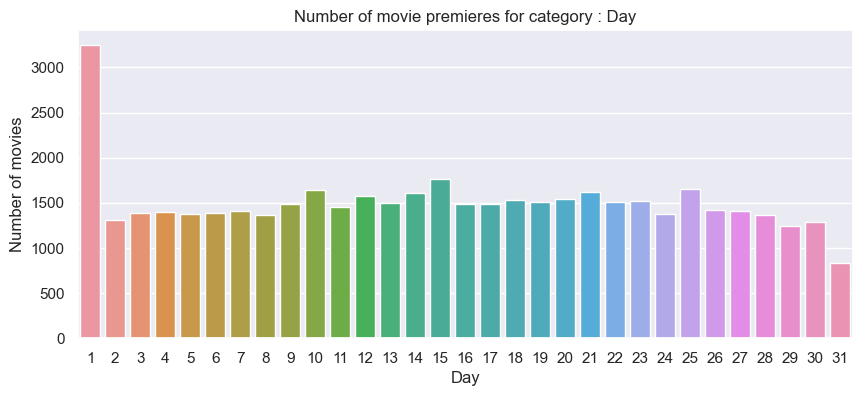

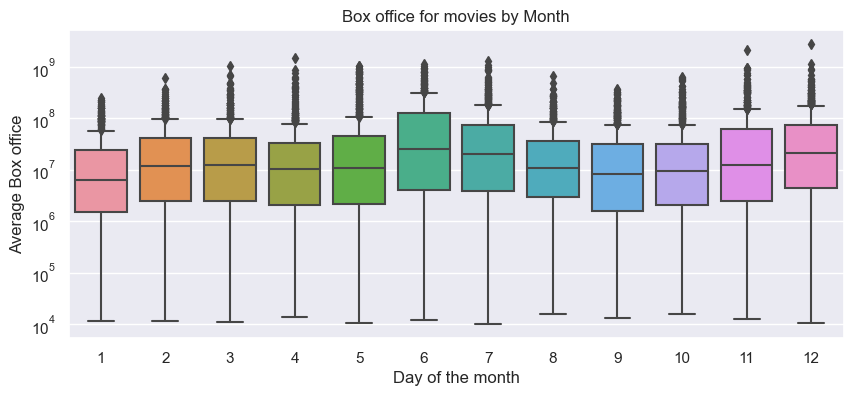

array([22506185.51886792, 36435692.90072202, 42417211.0508744 ,
       41391005.44594595, 74641828.06416276, 99081275.04347827,
       75734665.00696865, 32905312.33095578, 28216544.51950948,
       35680364.36615811, 68414144.87937063, 66646403.59235669])

In [33]:
#count_var(df_movie, 'Day')
#count_var(df_time_stamps, 'Weekday Name')
count_var(df_time_stamps, 'Day')
avg_var(df_time_stamps, 'Box office', 'Month')

In [25]:
# How many movies of each genre ? 


In [26]:
df_genre_list = df_time_stamps.copy(deep=True)

def get_genres(df):
    genres = dict()
    for i, element in enumerate(df['genres (Freebase ID:name tuples)']):
        t = json.loads(element)
        for v in t.items():
            if v[1] not in genres:
                genres[v[1]] = 0
                #print(genres)
            genres[v[1]] = genres[v[1]] + 1
    return genres

genres = get_genres(df_genre_list)
#genres = sorted(genres)
#print(genres)
#print(len(genres))

In [27]:
def get_movies_genre(df, genre):
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp['genres (Freebase ID:name tuples)'].str.contains(genre)==True] 
    return df_temp

def get_movies_country(df, country):
    df_temp = df.copy(deep=True)
    df_temp = df_temp[df_temp['Countries (Freebase ID:name tuples)'].str.contains(country)==False]
    return df_temp

In [28]:
sorted_genres = sorted(genres.items(), key=lambda x:x[1], reverse=True)
df_movie_genre = df_time_stamps.copy(deep=True)
df_movie_genre.dropna(subset=['Box office'], inplace=True)

n_genre = 20

list_genres = list(dict(sorted_genres).keys())[0:n_genre]

for i in range(10):
    boxoffice_mean = df_movie_genre[df_movie_genre['genres (Freebase ID:name tuples)']
                       .str.contains(sorted_genres[i][0])==True]['Box office'].mean()
    print(f'Average box office for {sorted_genres[i][0]} : {int(boxoffice_mean):,}, which represents {sorted_genres[i][1]:,} movies')


Average box office for Drama : 41,711,679, which represents 21,189 movies
Average box office for Comedy : 52,215,997, which represents 11,330 movies
Average box office for Romance Film : 45,809,834, which represents 7,024 movies
Average box office for Black-and-white : 6,236,742, which represents 6,544 movies
Average box office for Thriller : 71,745,214, which represents 6,238 movies
Average box office for Action : 89,187,861, which represents 5,777 movies
Average box office for Indie : 14,393,350, which represents 4,975 movies
Average box office for Crime Fiction : 51,635,503, which represents 4,719 movies
Average box office for World cinema : 20,251,801, which represents 4,489 movies
Average box office for Short Film : 31,881,762, which represents 4,429 movies


In [29]:
df_genre_list = []
for i in range(n_genre): # todo replace df_movie_genre with df_time_stamps
    temp_df = df_time_stamps[df_time_stamps['genres (Freebase ID:name tuples)']
                             .str.contains(sorted_genres[i][0])==True].copy(deep=True)
    temp_df['Genre'] = sorted_genres[i][0]
    df_genre_list.append(temp_df)

df_movie_genre = pd.concat(df_genre_list)

df_movie_genre.dropna(subset=['Genre'], inplace=True)


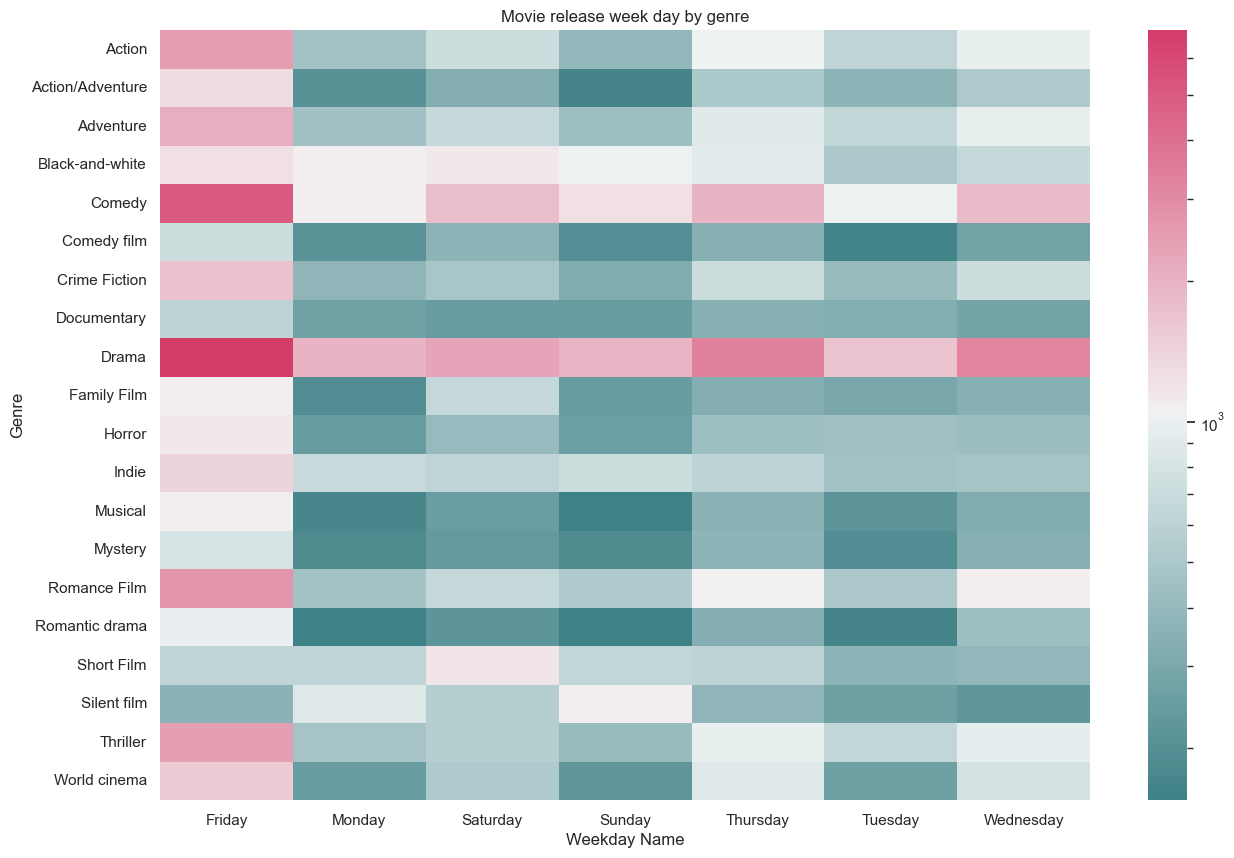

In [30]:
df_genre_weekday = pd.crosstab(df_movie_genre['Genre'],df_movie_genre['Weekday Name'])
plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_weekday, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True), norm=LogNorm())
plt.title('Movie release week day by genre')
plt.show()

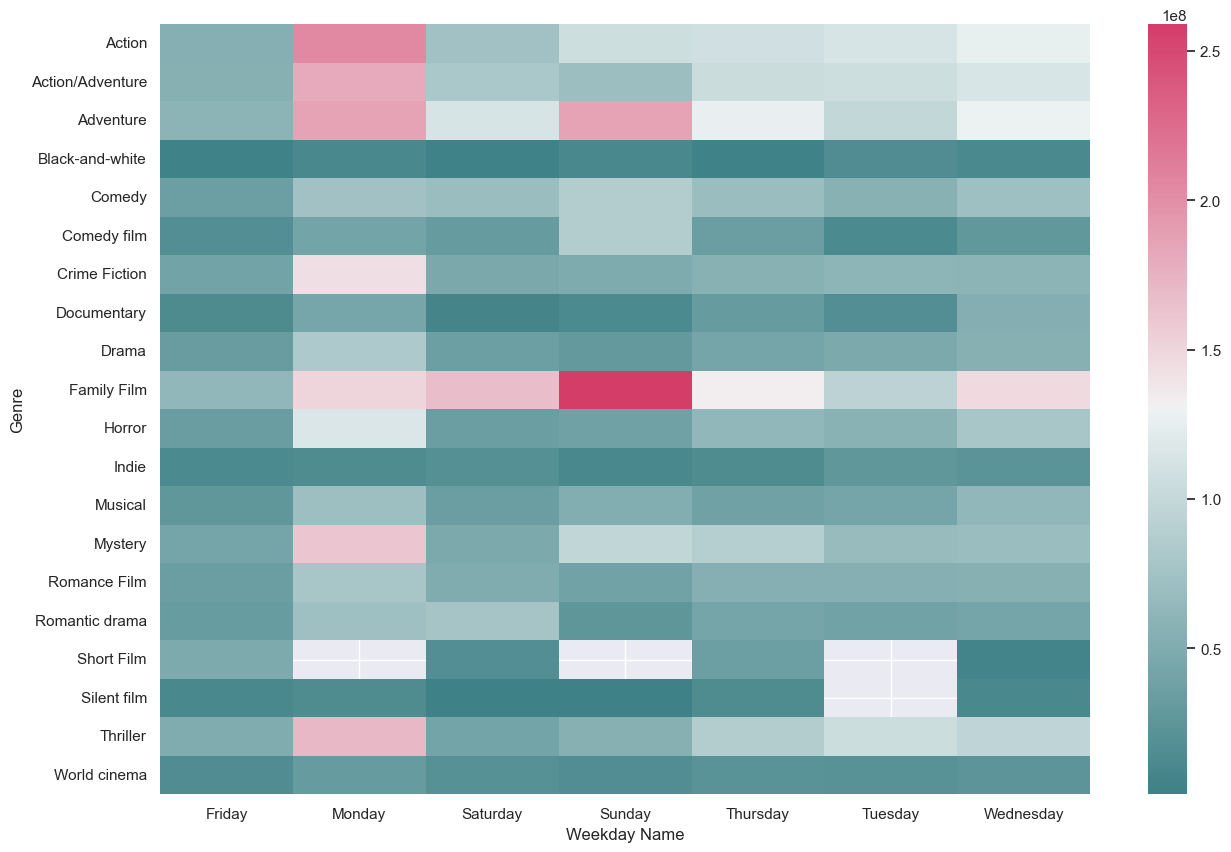

In [31]:
df_movie_genre_boxoffice = df_movie_genre.copy(deep=True)
df_movie_genre_boxoffice.dropna(subset=['Box office'], inplace=True)

df_genre_boxoffice = pd.crosstab(df_movie_genre_boxoffice['Genre'],df_movie_genre_boxoffice['Weekday Name'],
                  values=df_movie_genre_boxoffice['Box office'],aggfunc='mean')

plt.subplots(figsize=(15, 10))
sbn.heatmap(df_genre_boxoffice, annot=False, cmap=sbn.diverging_palette(200, 0, as_cmap=True))
plt.show()